# Install Kaggle API
In this notebook we we be using the kaggle api to download the sign-language-mnist dataset we are going to be using in this notebook. 

In order to download the sign-language-mnist dataset from kaggle, you first have to sign-up with kaggel.com, then download the api key from your account and then upload it with the kaggle auth helper function.  

For more information on have to create account or downloading the api key, please use search on goolge.

Note: Please make sure to store you api keys in a safe place.

In [1]:
kag = !pip list | grep kaggle
if len(kag) == 0:
  ! pip install kaggle
else:
  print('Kaggle api already installed')

Kaggle api already installed


In [0]:
# Helper function for uploading the kaggle auth key and moving it to the .kaggle
# directory for using with the kaggle api
def kaggle_auth():
  import os
  
  if not os.path.exists('/root/.kaggle/'):
    os.mkdir('/root/.kaggle')
  os.chdir('/root/.kaggle/')
  print(os.getcwd())

  if os.path.exists('/root/.kaggle/kaggle.json'):
    print('kaggle token exists')
  else:
    # upload the kaggle token to /content
    from google.colab import files
    print('Please upload your kaggle.json file')
    file = files.upload()
    token = list(file.keys())[0]
    os.rename(os.getcwd()+'/'+token, '/root/.kaggle/kaggle.json')
    os.chmod('/root/.kaggle/kaggle.json', 600)
    print('Uploaded kaggle token')

In [4]:
kaggle_auth()

/root/.kaggle
kaggle token exists


In [7]:
# searches the kaggle datasets database
! kaggle datasets list -s sign-language-mnist

ref                            title                size  lastUpdated          downloadCount  
-----------------------------  -------------------  ----  -------------------  -------------  
datamunge/sign-language-mnist  Sign Language MNIST  31MB  2017-10-20 15:09:18           7894  


In [51]:
import os
if not os.path.exists('/tmp/sign-language-mnist.zip'):
  # download the dataset from kagge
  # -p [path for the dataset to download to]
  # -d [name of dataset to be download]
  ! kaggle datasets download -p /tmp -d datamunge/sign-language-mnist

print('Zip downloaded')

Zip downloaded


# Step - 1 : Loading the Data
After download the dataset from kaggle, we can extract the zip file and then load the csv file into numpy arrays.

In [0]:
import csv
import numpy as np
import os, zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [35]:
# extracting the zip file 
if not os.path.exists('/tmp/sign-language-mnist'):
  ref_file = '/tmp/sign-language-mnist.zip'
  ref_zip = zipfile.ZipFile(ref_file, 'r')
  ref_zip.extractall('/tmp/sign-language-mnist')
  ref_zip.close()
  
print('dataset extracted')

dataset extracted


In [42]:
def get_data(filename):
  # loading the csv with numpy loadtxt function
  file = np.loadtxt(filename, skiprows=1, delimiter=',')
  labels = file[::, 0]  # first value in each row is the class
  # the rest if the image data and reshaping it into (28, 28)
  images = file[::, 1:].reshape(-1, 28, 28)
  return images, labels

train_csv = '/tmp/sign-language-mnist/sign_mnist_train.csv'
test_csv = '/tmp/sign-language-mnist/sign_mnist_test.csv'

training_images, training_labels = get_data(train_csv)
raw_testing_images, raw_testing_labels = get_data(test_csv)

# Checking the shapes 
print(training_images.shape)
print(training_labels.shape)
print(raw_testing_images.shape)
print(raw_testing_labels.shape)

(27455, 28, 28)
(27455,)
(7172, 28, 28)
(7172,)


In [57]:
# Creating hidden dataset for testing after training
n_hidden = np.random.randint(20, 40)  # pick random integer inbetween 80 to 100
# Pick random indices from testing data set
hidden_idx = np.random.choice(len(raw_testing_images), size=n_hidden, replace=False)
arange = np.arange(len(raw_testing_images))
test_idx = np.isin(arange, hidden_idx) == False

hidden_images = raw_testing_images[hidden_idx]
hidden_labels = raw_testing_labels[hidden_idx]

testing_images = raw_testing_images[test_idx]
testing_labels = raw_testing_labels[test_idx]

# Checking the shapes
print(testing_images.shape)
print(testing_labels.shape)
print(hidden_images.shape)
print(hidden_labels.shape)

(7142, 28, 28)
(7142,)
(30, 28, 28)
(30,)


# Step - 2: Preprocessing the Data

In [62]:
# In this section you will have to add another dimension to the data
# So, for example, if your array is (10000, 28, 28)
# You will need to make it (10000, 28, 28, 1)
# Hint: np.expand_dims

if len(training_images.shape) < 4:
  training_images = np.expand_dims(training_images, axis=-1)
if len(testing_images.shape) < 4:
  testing_images = np.expand_dims(testing_images, axis=-1)

# Create an ImageDataGenerator and do Image Augmentation
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   rotation_range=40,
                                   width_shift_range=.2,
                                   height_shift_range=.2,
                                   zoom_range=.2,
                                   shear_range=.2,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255.)
    
# checking the shapes 
print(training_images.shape)
print(testing_images.shape)

(27455, 28, 28, 1)
(7142, 28, 28, 1)


# Step - 3: Create the Model

In [0]:
class myCallback(tf.keras.callbacks.Callback):
  def __init__(self, p=0.9):
    self.p = p
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('acc')>self.p):
      print("\nReached {:.2f}% training accuracy, training STOP!".format(self.p*100))
      self.model.stop_training = True

In [0]:
# Define the model with 2 Conv2D and 2 MaxPooling2D
# and a dropout layer
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(28,28,1)),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1024, activation='relu'),
  tf.keras.layers.Dropout(.2),
  tf.keras.layers.Dense(training_labels.max()+1, activation='softmax')
  ])

# Compile Model. 
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])


In [66]:
callbacks = myCallback(p=.8)
# Train the Model
history = model.fit_generator(train_datagen.flow(training_images, 
                                                 training_labels, 
                                                 batch_size=32),
                              steps_per_epoch=len(training_images)/32,
                              epochs=100,
                              validation_data=validation_datagen.flow(testing_images, 
                                                                      testing_labels, 
                                                                      batch_size=32),
                              validation_steps=len(testing_images)/32,
                              callbacks=[callbacks])

Epoch 1/100
858/857 [==============================] - 12s 14ms/step - loss: 0.7986 - acc: 0.7287 - val_loss: 0.4142 - val_acc: 0.8472
Epoch 2/100
858/857 [==============================] - 12s 14ms/step - loss: 0.7529 - acc: 0.7435 - val_loss: 0.4089 - val_acc: 0.8516
Epoch 3/100
858/857 [==============================] - 12s 14ms/step - loss: 0.7182 - acc: 0.7555 - val_loss: 0.3631 - val_acc: 0.8701
Epoch 4/100
858/857 [==============================] - 12s 14ms/step - loss: 0.6957 - acc: 0.7638 - val_loss: 0.3135 - val_acc: 0.9079
Epoch 5/100
858/857 [==============================] - 12s 14ms/step - loss: 0.6639 - acc: 0.7763 - val_loss: 0.2729 - val_acc: 0.9087
Epoch 6/100
858/857 [==============================] - 12s 14ms/step - loss: 0.6445 - acc: 0.7827 - val_loss: 0.2282 - val_acc: 0.9278
Epoch 7/100
858/857 [==============================] - 12s 14ms/step - loss: 0.6179 - acc: 0.7908 - val_loss: 0.3104 - val_acc: 0.8869
Epoch 8/100
858/857 [==============================] - 

### Plotting the history

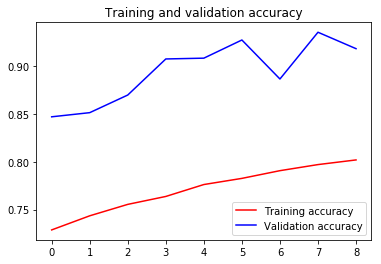

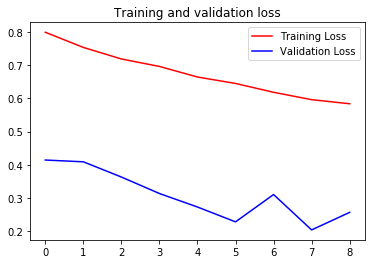

In [68]:
# Plot the chart for accuracy and loss on both training and validation
print(history)

import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Step - 4: Testing the Model

In [69]:
# create a python dictionary for the letters in the alphabet
import string
alphabet = string.ascii_uppercase
al_key = {i:a for i, a in enumerate(alphabet)}
print(al_key)

{0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M', 13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y', 25: 'Z'}


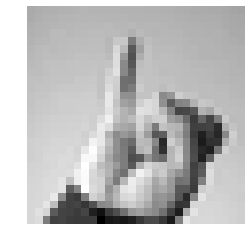

The model guess the above sign to be I, and the sign is I, therefore the model's is correct :)!


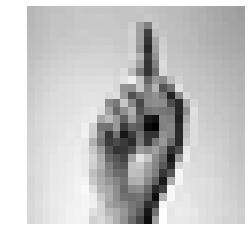

The model guess the above sign to be D, and the sign is D, therefore the model's is correct :)!


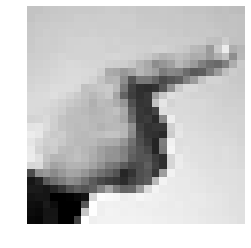

The model guess the above sign to be G, and the sign is G, therefore the model's is correct :)!


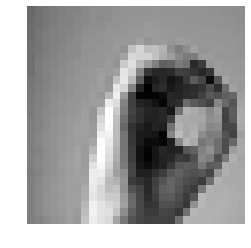

The model guess the above sign to be O, and the sign is O, therefore the model's is correct :)!


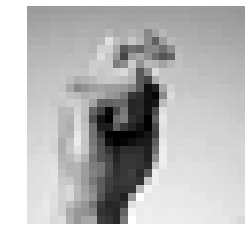

The model guess the above sign to be X, and the sign is X, therefore the model's is correct :)!


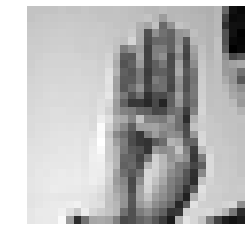

The model guess the above sign to be B, and the sign is B, therefore the model's is correct :)!


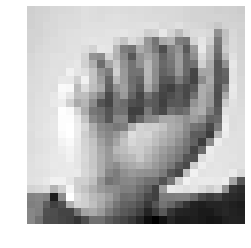

The model guess the above sign to be A, and the sign is A, therefore the model's is correct :)!


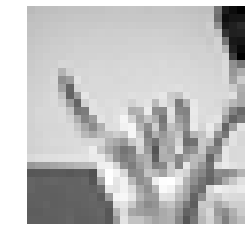

The model guess the above sign to be Y, and the sign is Y, therefore the model's is correct :)!


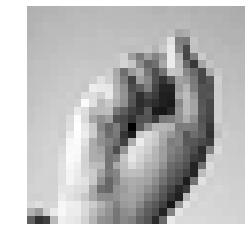

The model guess the above sign to be S, and the sign is S, therefore the model's is correct :)!


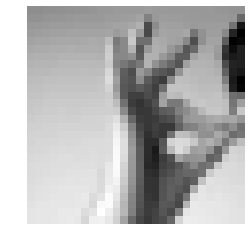

The model guess the above sign to be F, and the sign is F, therefore the model's is correct :)!


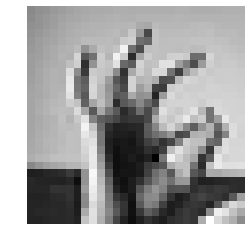

The model guess the above sign to be F, and the sign is F, therefore the model's is correct :)!


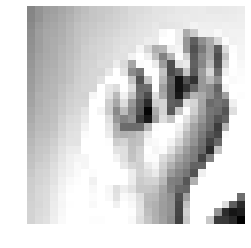

The model guess the above sign to be N, and the sign is N, therefore the model's is correct :)!


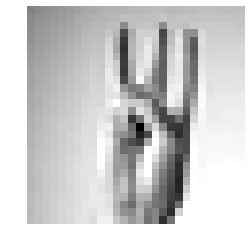

The model guess the above sign to be W, and the sign is W, therefore the model's is correct :)!


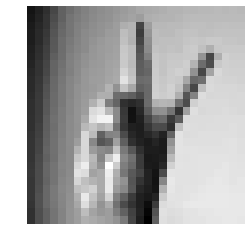

The model guess the above sign to be V, and the sign is V, therefore the model's is correct :)!


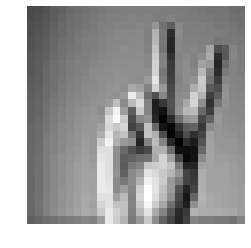

The model guess the above sign to be V, and the sign is V, therefore the model's is correct :)!


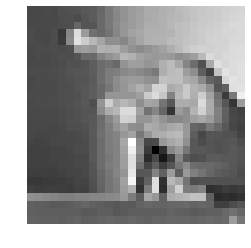

The model guess the above sign to be P, and the sign is P, therefore the model's is correct :)!


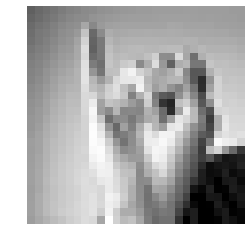

The model guess the above sign to be I, and the sign is I, therefore the model's is correct :)!


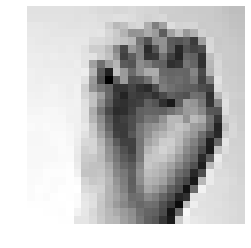

The model guess the above sign to be E, and the sign is E, therefore the model's is correct :)!


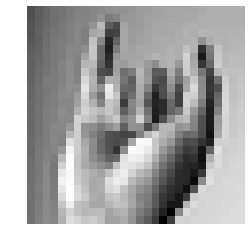

The model guess the above sign to be I, and the sign is I, therefore the model's is correct :)!


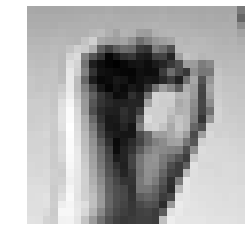

The model guess the above sign to be O, and the sign is O, therefore the model's is correct :)!


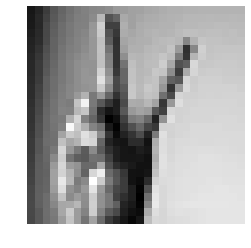

The model guess the above sign to be V, and the sign is V, therefore the model's is correct :)!


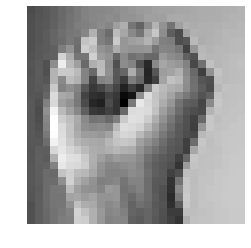

The model guess the above sign to be S, and the sign is S, therefore the model's is correct :)!


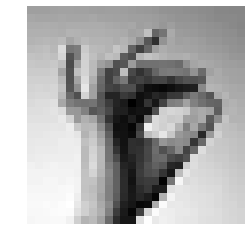

The model guess the above sign to be F, and the sign is F, therefore the model's is correct :)!


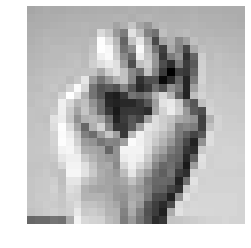

The model guess the above sign to be M, and the sign is M, therefore the model's is correct :)!


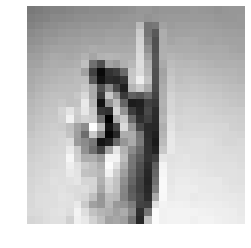

The model guess the above sign to be K, and the sign is K, therefore the model's is correct :)!


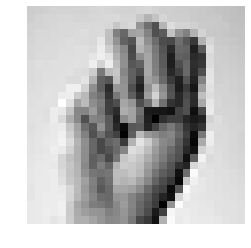

The model guess the above sign to be M, and the sign is M, therefore the model's is correct :)!


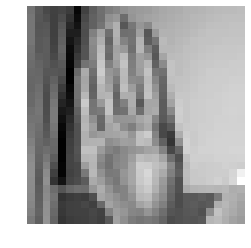

The model guess the above sign to be I, and the sign is B, therefore the model's is incorrect :(!


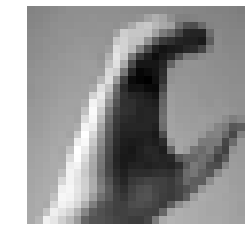

The model guess the above sign to be C, and the sign is C, therefore the model's is correct :)!


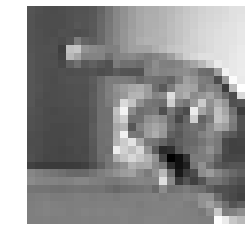

The model guess the above sign to be P, and the sign is P, therefore the model's is correct :)!


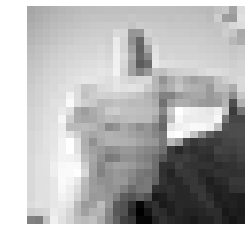

The model guess the above sign to be T, and the sign is T, therefore the model's is correct :)!
The model's test accuracy is 96.67%


In [70]:
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from PIL import Image

score = 0
for image, label in zip(hidden_images, hidden_labels):
  plt.imshow(image, cmap='gray')
  plt.axis('off')
  plt.show()
  
  img = np.expand_dims(image, axis=-1)/255.
  p = model.predict(np.expand_dims(img, axis=0))
  predict = np.argmax(p)
  is_correct = 'correct :)!' if predict==label else 'incorrect :(!'
  if is_correct == 'correct :)!':
    score += 1
  print('The model guess the above sign to be {}, and the sign is {}, '
        "therefore the model's is {}".format(al_key[predict], 
                                             al_key[int(label)],
                                             is_correct))

print("The model's test accuracy is {:.2f}%".format(score/len(hidden_labels)*100))